<a href="https://colab.research.google.com/github/elliottabe/pytorchGLM/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installing repo and dependencies
!pip install -U matplotlib &> /dev/null
!git clone https://github.com/elliottabe/pytorchGLM.git &> /dev/null
!pip install -r ./pytorchGLM/requirements.txt &> /dev/null
!pip install git+https://github.com/elliottabe/pytorchGLM.git &> /dev/null

In [ ]:
import zipfile
from IPython.display import clear_output
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X1dpHDy0zblsVmW-8lC6Vji8g2x0s0bY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1X1dpHDy0zblsVmW-8lC6Vji8g2x0s0bY" -O 070921.zip && rm -rf /tmp/cookies.txt

with zipfile.ZipFile('/content/070921.zip', 'r') as zip_ref:
    zip_ref.extractall('Testing')


# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import warnings 
warnings.filterwarnings('ignore')
import logging
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray import air

import torch
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Custom package #####
import pytorchGLM as pglm
from pytorchGLM.main.training import train_network

##### Plotting settings ######
import matplotlib as mpl

mpl.rcParams.update({'font.size':         10,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })


# Format Data

## Loading  Niell lab Raw Data

In [2]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] #,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['base_dir']        = './Testing'
args['fig_dir']         = './FigTesting'
args['data_dir']        = './'
args['free_move']       = True
args['train_shifter']   = False
args['Nepochs']         = 1000

ModelID = 1
params, file_dict, exp = pglm.load_params(args,ModelID,file_dict={},exp_dir_name=None,nKfold=0,debug=False)


In [3]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
params = pglm.get_modeltype(params)
datasets, network_config,initial_params = pglm.load_datasets(file_dict,params,single_trial=True)


Tot_units: (128,)
Good_units: (108,)


In [4]:
x,xpos,y = datasets['xtr'][:10],datasets['xtr_pos'][:10],datasets['ytr'][:10]
print(x.shape,xpos.shape,y.shape)

torch.Size([10, 3000]) torch.Size([10, 4]) torch.Size([10, 108])


## Single Trial Training on Niell Lab data

In [7]:
network_config['L2_lambda'] = 13

In [8]:
tloss_trace,vloss_trace,model,optimizer = train_network(network_config,**datasets, params=params,filename=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
RFs = model.Cell_NN[0].weight.reshape((params['Ncells'],params['nt_glm_lag'])+params['nks']).cpu().detach().numpy()

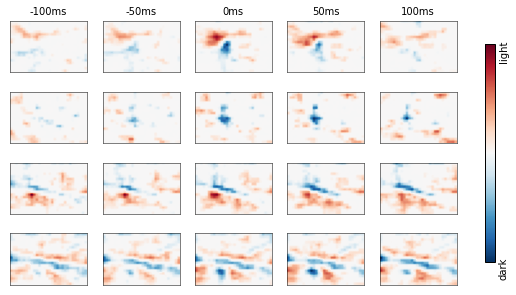

In [10]:
cells = [22,34,42,101]
lag_list = [0,1,2,3,4]
lag_ls = [-100,-50,0,50,100]
fig, axs = plt.subplots(4,5,figsize=(10,5))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(RFs[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs[n,m]
        im = ax.imshow(RFs[cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs[0,m].set_title('{}ms'.format(lag_ls[m]),fontsize=10)


cbar2 = fig.colorbar(im, ax=axs,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=10, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

## Formatting Raw Data

load_aligned_data calls 2 functions when preprocessing the raw data: 
- format_raw_data: formats the raw data based on file_dict and params
- interp_raw_data: interpolates the formamted data from format_raw_data

In [ ]:
raw_data, goodcells = pglm.format_raw_data(file_dict,params)
model_data = pglm.interp_raw_data(raw_data,raw_data['vid']['vidTS'],model_dt=params['model_dt'],goodcells=goodcells)

## Custom Dataset Formatting Base Model

This section is dedicated to formatting any custom datasets. The key components are: 
- Formatting data
    - Train/Test Splits
    - Inputs (time,in_features)
    - Optional Inputs (time,pos_features)
    - Outputs (time,Ncells)
- network_config
    - in_features: input dims
    - Ncells: output dims
    - initW: How to initialize weights, 'zero' or 'normal' 
    - optimizer: optmimizer to use: 'adam' or 'sgd'
    - lr_w: learning rate for weights
    - lr_b: learning rate for bias
    - lr_m: learning rate for additional inputs
    - single_trial: flag for single trial or hyperparam seach
    - L1_alpha: L1 regularization parameter. Single value or hyperparam search
    - L1_alpham: L1 regularization parameter. Single value or hyperparam search
    - L2_lambda: L2 regularization parameter. Single value or hyperparam search
    - L2_lambda_m: L2 regularization parameter. Single value or hyperparam search

In [ ]:
args = pglm.arg_parser(jupyter=True)
args

In [ ]:
#@title Custom load functions

def load_BaseModel_params(args,exp_dir_name='Testing',ModelID=0,nKfold=0,debug=False):
    """ Load parameter dictionary for custom BaseModel network. Minimal implementation 
        adabpting to custom datasets

    Args:
        args (dict): Argument dictionary 
        exp_dir_name (str): name of experiment. 
        ModelID (int, optional): Model Identification number. Defaults to 0.
        exp_dir_name (str, optional): Optional experiment directory name if using own data. Defaults to None.
        nKfold (int, optional): Kfold number for versioning. Defaults to 0.
        debug (bool, optional): debug=True does not create experiment directories. Defaults to False.

    Returns:
        params (dict): dictionary of parameters
        exp (obj): Test_tube object for organizing files and tensorboard
    """
    import yaml
    from pathlib import Path
    from test_tube import Experiment
    
    ##### Create directories and paths #####
    date_ani2 = '_'.join(args['date_ani'].split('/'))
    data_dir = Path(args['data_dir']).expanduser() / args['date_ani'] / args['stim_cond'] 
    base_dir = Path(args['base_dir']).expanduser()
    save_dir = (base_dir / args['date_ani'] / args['stim_cond'])
    save_dir.mkdir(parents=True, exist_ok=True)
    base_dir.mkdir(parents=True, exist_ok=True)

    ##### Set up test_tube versioning #####
    exp = Experiment(name='ModelID{}'.format(ModelID),
                        save_dir=save_dir / exp_dir_name, 
                        debug=debug,
                        version=nKfold)

    save_model = exp.save_dir / exp.name / 'version_{}'.format(nKfold)

    params = {
        ##### Data Parameters #####
        'data_dir':                 data_dir,
        'base_dir':                 base_dir,
        'exp_name_base':            base_dir.name,
        'stim_cond':                args['stim_cond'],
        'save_dir':                 save_dir,
        'exp_name':                 exp.save_dir.name,
        'save_model':               save_model,
        'date_ani2':                date_ani2,
        'model_dt':                 args['model_dt'],
        ##### Model Parameters #####
        'ModelID':                  ModelID,
        'lag_list':                 [0], # List of which timesteps to include in model fit
        'Nepochs':                  args['Nepochs'],
        'Kfold':                    args['Kfold'],
        'NoL1':                     args['NoL1'],
        'NoL2':                     args['NoL2'],
        'initW':                    'zero',
        'train_shifter':            False,
        'model_type':               'pytorchGLM_custom', # For naming files
    }

    params['nt_glm_lag']=len(params['lag_list']) # number of timesteps for model fits
    params['data_name'] = '_'.join([params['date_ani2'],params['stim_cond']])
    
    ##### Saves yaml of parameters #####
    if debug==False:
        params2=params.copy()
        for key in params2.keys():
            if isinstance(params2[key], Path):
                params2[key]=params2[key].as_posix()

        pfile_path = save_model / 'model_params.yaml'
        with open(pfile_path, 'w') as file:
            doc = yaml.dump(params2, file, sort_keys=True)

    return params, exp


def initialize_GP_inputs(Npats,length_scale,batch_size,Nx_low,Nx,Ny_star,Nr,seed=42,multi_input=False,pytorch=True):
    from sklearn.gaussian_process.kernels import RBF

    ##### Set random seed #####
    np.random.seed(seed+1)
    torch.manual_seed(seed+1)
    ##### Initialize RBF kernels #####
    rbf = RBF(length_scale=length_scale)
    genX = np.arange(Npats)[:,np.newaxis]
    genY = np.arange(Npats)[:,np.newaxis]
    Kx = rbf(genX,genX)
    Ky = rbf(genY,genY)
    if multi_input:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_low1 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x0 = torch.bmm(x_low0,x_expand)
        x1 = torch.bmm(x_low1,x_expand)
        x_all = torch.stack((x0,x1),dim=1).float()
        ##### Initialize target patterns #####
        y_all = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Ny_star,Nr))),3,2)
        y_all = ((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1,1))
    else:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x_all = torch.bmm(x_low0,x_expand)#.numpy()
        # x_all = torch.from_numpy((x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)).float()
        ##### Initialize target patterns #####
        y_all = torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Nr)))
        y_all = torch.transpose((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1),-1,-2)

    if pytorch:
        x_all = x_all.float()
        y_all = y_all.float()
    else:
        x_all = x_all.float().numpy()
        y_all = y_all.float().numpy()

    return x_all, y_all


In [ ]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = './Testing'
args['fig_dir']         = './FigTesting'
args['data_dir']        = './'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = False
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
##### Generating data #####
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=10,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = (x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)

##### Train/Test Splits ####
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr,xte = x_all[train_idx], x_all[test_idx]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[train_idx], y_all[test_idx]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)
params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
meanbias = torch.mean(y_all,dim=0)

xtr, xte, xtr_pos, xte_pos, ytr, yte, meanbias=xtr.to(device), xte.to(device), xtr_pos.to(device), xte_pos.to(device), ytr.to(device), yte.to(device), meanbias.to(device)
datasets = {
            'xtr':xtr,
            'xte':xte,
            'xtr_pos':xtr_pos,
            'xte_pos':xte_pos,
            'ytr':ytr,
            'yte':yte,
            'meanbias':meanbias,
        }


In [ ]:
params['initW'] = 'normal' #'zero' # 'normal'
params['optimizer'] = 'sgd'
network_config,initial_params = pglm.make_network_config(params,single_trial=0,custom=True)
network_config['lr_w'] = .001
network_config['lr_b'] = .1

In [ ]:
tloss_trace,vloss_trace,model,optimizer = train_network(network_config,**datasets, params=params,filename=None)

In [ ]:
##### Make prediction #####
yhat = model(xte.to(device),xte_pos.to(device)).detach().cpu().numpy().squeeze()
yt = yte.cpu().detach().numpy().squeeze()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
cmap = pglm.discrete_cmap(vloss_trace.shape[-1],'jet')
for cell in range(vloss_trace.shape[-1]):
    ax.plot(vloss_trace[:,cell],c=cmap(cell))
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vloss_trace.shape[-1]))
cbar = fig.colorbar(sm,ax=ax,format=None,shrink=0.7,pad=0.01)
cbar.outline.set_linewidth(1)
cbar.set_label('output dim')
cbar.ax.tick_params(labelsize=12, width=1,direction='in')

ncell = 0
ax = axs[1]
ax.plot(yt[:,ncell],c='k',label='actual')
ax.plot(yhat[:,ncell],c='r',label='predicted')
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.set_title('cc={:.03}'.format(np.corrcoef(yhat[:,ncell],yt[:,ncell])[1,0]))
ax.legend(fontsize=10,ncol=1,labelcolor='linecolor', markerscale=0, handlelength=0, handletextpad=0,loc="upper left",frameon=False, bbox_to_anchor=(.8, 1))
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
x_all2,y_all2 = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=50,pytorch=False)
x_all2, y_all2 = x_all2.squeeze(),y_all2.squeeze()
y_all2 = (y_all2+1)/2
x_all2 = x_all2/np.max(np.abs(x_all2))
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all2.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all2.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr2,xte2 = x_all2[train_idx], x_all2[test_idx]
xtr_pos2,xte_pos2 = np.zeros_like(xtr2),np.zeros_like(xte2)
ytr2,yte2 = y_all2[train_idx], y_all2[test_idx]


l1 = LinearRegression()
l1.fit(xtr2,ytr2)
yhat2 = l1.predict(xte2)
print('cc=',np.corrcoef(yhat2[:,ncell],yte2[:,ncell])[0,1])

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
ax = axs
ax.plot(yt[:,ncell],c='k',label='actual')
ax.plot(yhat2[:,ncell],c='r',label='predicted')
ax.legend(fontsize=10,ncol=1,labelcolor='linecolor', markerscale=0, handlelength=0, handletextpad=0,loc="upper left",frameon=False, bbox_to_anchor=(.8, 1))
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.set_title('cc={:.03}'.format(np.corrcoef(yhat2[:,ncell],yt[:,ncell])[1,0]))


# Ray Tune Training: Parallel Cross Validation

For details about Ray Tune see: https://docs.ray.io/en/latest/tune/key-concepts.html

## Training Ray Tune Hyper Params Search Neill Lab data

In [ ]:
args['num_samples'] = 2
ModelID = 1
params, file_dict, exp = pglm.load_params(args,ModelID,file_dict={},exp_dir_name=None,nKfold=0,debug=False)


In [ ]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
params = pglm.get_modeltype(params)
datasets, network_config,initial_params = pglm.load_datasets(file_dict,params,single_trial=False)


Tot_units: (128,)
Good_units: (108,)


In [ ]:
algo = HyperOptSearch(points_to_evaluate=initial_params)
algo = ConcurrencyLimiter(algo, max_concurrent=4)
num_samples = args['num_samples']
sync_config = tune.SyncConfig()  # the default mode is to use use rsync
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(pglm.train_network,**datasets,params=params),
        resources={"cpu":args['cpus_per_task'], "gpu": args['gpus_per_task']}),
    tune_config=tune.TuneConfig(metric="avg_loss",mode="min",search_alg=algo,num_samples=num_samples),
    param_space=network_config,
    run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config)
)
results = tuner.fit()

best_result = results.get_best_result("avg_loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
df = results.get_dataframe()
best_network = list(params['save_model'].rglob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]
exp_filename = '_'.join([params['model_type'],params['data_name_fm']]) + 'experiment_data.h5'
exp_best_dict = {'best_network':best_network,'trial_id':best_result.metrics['trial_id'],'best_config':best_result.config}
pglm.h5store(params['save_model'] / ('NetworkAnalysis/{}'.format(exp_filename)), df, **exp_best_dict)

##### Evaluate hyperparameter search #####
pglm.evaluate_networks(best_network,best_result.config,params,datasets['xte'],datasets['xte_pos'],datasets['yte'],device=device)

## Ray Tune for Custom Datasets

In [ ]:
import ray
from ray import tune
from ray.air import session
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import hp

In [ ]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = './Testing'
args['fig_dir']         = './FigTesting'
args['data_dir']        = './'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = True
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

from sklearn.model_selection import GroupShuffleSplit

##### Generating data #####
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=10,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = (x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)

##### Train/Test Splits ####
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr,xte = x_all[train_idx], x_all[test_idx]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[train_idx], y_all[test_idx]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)

params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
meanbias = torch.mean(y_all,dim=0)
xtr, xte, xtr_pos, xte_pos, ytr, yte, meanbias=xtr.to(device), xte.to(device), xtr_pos.to(device), xte_pos.to(device), ytr.to(device), yte.to(device), meanbias.to(device)
datasets = {
            'xtr':xtr,
            'xte':xte,
            'xtr_pos':xtr_pos,
            'xte_pos':xte_pos,
            'ytr':ytr,
            'yte':yte,
            'meanbias':meanbias,
        }

params['initW'] = 'normal' #'zero' # 'normal'
params['optimizer'] = 'sgd'
network_config, initial_params = pglm.make_network_config(params,custom=True)
network_config['lr_w'] = tune.loguniform(1e-4, 1e-2)
network_config['lr_b'] = tune.loguniform(1e-2, 1)

`network_config` contains the key parameters for the network and this is where we can choose which hyperparameters to optimize. In this example, we will optimize the learning rate of the weights and bias of the network to get the best fit. 

In [ ]:
initial_params = [
    {"lr_w": 0.001,"lr_b": 0.1, },
]
algo = HyperOptSearch(points_to_evaluate=initial_params)
algo = ConcurrencyLimiter(algo, max_concurrent=4)
num_samples = 10

In [ ]:
ray.init(ignore_reinit_error=True,include_dashboard=True)

sync_config = tune.SyncConfig()  # the default mode is to use use rsync
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_network,**datasets, params=params),
        resources={"cpu": 2, "gpu": .5}),
    tune_config=tune.TuneConfig(metric="avg_loss",mode="min",search_alg=algo,num_samples=num_samples),
    param_space=network_config,
    run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config,verbose=2)
)
results = tuner.fit()

best_result = results.get_best_result("avg_loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
##### Get experiment dataframe and best network
df = results.get_dataframe()
best_network = list(params['save_model'].rglob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]

##### Save experiment data and save best network as h5 #####
exp_filename = '_'.join([params['model_type'],params['data_name']]) + 'experiment_data.h5'
exp_best_dict = {'best_network':best_network,'trial_id':best_result.metrics['trial_id'],'best_config':best_result.config}
pglm.h5store(params['save_model'] / ('NetworkAnalysis/{}'.format(exp_filename)), df, **exp_best_dict)


In [ ]:
#@title Custom Evaluate_network Fuction

def custom_eval(best_network,network_config,params,xte,xte_pos,yte,device='cpu'):
    """Evaluates ray tune experiment and hyperparameter search

    Args:
        best_network (str): path to best network model '.pt' file
        network_config (dict): network_config for best network
        params (dict): key parameters dictionary
        xte (Tensor): test input data 
        xte_pos (Tensor): test additional input data
        yte (Tensor): target test data
        device (str, optional): device to load data onto. Defaults to 'cpu'.
    """
    import pytorchGLM.Utils.io_dict_to_hdf5 as ioh5
    from pytorchGLM.main.models import model_wrapper,BaseModel

    ##### Load best network from saved ray experiment ######
    state_dict, _ = torch.load(best_network,map_location='cpu')
    model = model_wrapper((network_config,BaseModel))
    model.load_state_dict(state_dict)
    model.to(device)

    ##### Load data into device and predict test set ######
    xte, xte_pos, yte = xte.to(device), xte_pos.to(device), yte.to(device)
    with torch.no_grad():
        yhat = model(xte,xte_pos)

    ##### Smooth Firing rates and save ######
    actual_smooth = yte.detach().cpu().numpy()
    pred_smooth = yhat.detach().cpu().numpy()
    cc_test = np.array([(np.corrcoef(pred_smooth[:,celln],actual_smooth[:,celln])[0, 1]) for celln in range(pred_smooth.shape[1])])
    
    GLM_Dict = {
        'actual_smooth': actual_smooth,
        'pred_smooth': pred_smooth,
        'cc_test': cc_test,
        }

    for key in state_dict.keys():
        GLM_Dict[key]  = state_dict[key].cpu().numpy()

    model_name = '{}_ModelID{:d}_dt{:03d}_T{:02d}_NB{}_Best.h5'.format(params['model_type'], params['ModelID'],int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'])
    ioh5.save(params['save_model']/model_name,GLM_Dict)


In [ ]:
custom_eval(best_network,network_config,params,xte,xte_pos,yte,device='cpu')

In [ ]:
exp_filename = list((params['save_model']/'NetworkAnalysis').rglob('*experiment_data.h5'))[0]
df,meta_data = pglm.h5load(exp_filename)
best_network=meta_data['best_network']
best_config = meta_data['best_config']

In [ ]:
import pytorchGLM.Utils.io_dict_to_hdf5 as ioh5
model_name = '{}_ModelID{:d}_dt{:03d}_T{:02d}_NB{}_Best.h5'.format(params['model_type'], params['ModelID'],int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'])
GLM_Data = ioh5.load(params['save_model']/model_name)

In [ ]:
GLM_Data.keys()